In [6]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [7]:
# Step 2: Load Data with Correct Header Handling
# Read with dual headers and handle BOM encoding
df = pd.read_csv('kaggle_survey_2017_2021.csv', header=[0, 1], encoding='utf-8-sig')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4616\474633397.py:3: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,20,22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,89,90,91,92,94,95,96,97,98,99,101,102,103,104,105,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,152,153,154,155,156,157,158,159,160,161,162,163,164,165,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,239,240,241,242,243,244,245,246,247,248,249,250,251,252,254,255,256,257,258,259,260,261,262,263,264,265,266,268,269,270,271,27

In [8]:
# Step 3: Create Unified Column Names
new_columns = []
for col in df.columns:
    # Handle unnamed secondary headers
    if 'Unnamed' in col[1]:
        new_columns.append(col[0])
    else:
        # Combine both header levels
        new_columns.append(f"{col[0]}_{col[1]}")

In [9]:
df.columns = new_columns

In [10]:
# Remove original header rows (first two rows)
df = df.iloc[2:].reset_index(drop=True)

In [11]:
# Step 4: Fix Demographic Column Names
# Define demographic columns using CORRECT unified names
demographic_cols = [
    'Time from Start to Finish (seconds)_Duration (in seconds)',
    'Q1_What is your age (# years)?',
    'Q2_What is your gender? - Selected Choice',
    'Q3_In which country do you currently reside?',
    'Q4_What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
    'Q5_Select the title most similar to your current role (or most recent title if retired): - Selected Choice'
]

In [12]:
# Handle missing values for demographic columns
df[demographic_cols] = df[demographic_cols].fillna('Unknown')

In [13]:
# Step 5: Handle Multi-Select Columns
# Identify all multi-select columns (contain "Part_")
multi_select_cols = [col for col in df.columns if 'Part_' in col]
df[multi_select_cols] = df[multi_select_cols].fillna(0)

In [14]:
# Convert to integers where possible
for col in multi_select_cols:
    try:
        df[col] = df[col].astype(int)
    except ValueError:
        # Keep as string if conversion fails
        pass

In [15]:
# Step 6: Remove Duplicates
print(f"Original shape: {df.shape}")
df = df.drop_duplicates()
print(f"After deduplication: {df.shape}")

Original shape: (106299, 293)
After deduplication: (101843, 293)


In [16]:
# Step 7: Fix Encoding Issues
# Clean special characters in all string columns
string_cols = df.select_dtypes(include='object').columns
df[string_cols] = df[string_cols].apply(lambda x: x.str.replace('â€™', "'", regex=False))

In [17]:
# Step 8: Clean Specific Columns
# Gender standardization
gender_mapping = {
    'Male': 'Man',
    'Female': 'Woman',
    'Prefer to self-describe': 'Non-binary',
    'Prefer not to say': 'Prefer not to say'
}
df['Q2_What is your gender? - Selected Choice'] = df['Q2_What is your gender? - Selected Choice'].replace(gender_mapping)

In [18]:
# Compensation cleaning
def clean_compensation(value):
    if pd.isna(value) or value in ['Unknown', 'I do not wish to disclose my approximate yearly compensation']:
        return np.nan
    
    # Clean string values
    value = str(value).replace('$', '').replace(',', '').replace('>', '').strip()
    
    # Handle ranges
    if '-' in value:
        low, high = value.split('-')[:2]
        try:
            return (float(low) + float(high)) / 2
        except:
            return np.nan
    # Handle + indicators
    elif '+' in value:
        try:
            return float(value.replace('+', ''))
        except:
            return np.nan
    else:
        try:
            return float(value)
        except:
            return np.nan

In [19]:
comp_col = 'Q25_What is your current yearly compensation (approximate $USD)?'
df[comp_col] = df[comp_col].apply(clean_compensation)

In [20]:
# Step 9: Label Encoding for Categorical Variables
categorical_cols = [
    'Q1_What is your age (# years)?', 
    'Q2_What is your gender? - Selected Choice',
    'Q3_In which country do you currently reside?',
    'Q4_What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
    'Q5_Select the title most similar to your current role (or most recent title if retired): - Selected Choice'
]

In [21]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Handle new categories with 'Unknown'
    df[col] = df[col].fillna('Unknown')
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4616\798887053.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_encoded'] = le.fit_transform(df[col])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_4616\798887053.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_encoded'] = le.fit_transform(df[col])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_4616\798887053.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [23]:
# Step 10: Extract and Visualize Insights
# Programming language analysis
python_col = 'Q7_Part_1_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python'
r_col = 'Q7_Part_2_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R'
sql_col = 'Q7_Part_3_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL'

# Convert to binary indicators (1 if selected, 0 otherwise)
df[python_col] = np.where(df[python_col].astype(str).str.contains("Python", na=False), 1, 0)
df[r_col] = np.where(df[r_col].astype(str).str.contains("R", na=False), 1, 0)
df[sql_col] = np.where(df[sql_col].astype(str).str.contains("SQL", na=False), 1, 0)

language_usage = {
    'Python': df[python_col].sum(),
    'R': df[r_col].sum(),
    'SQL': df[sql_col].sum()
}

Text(0.5, 0, 'Number of Users')

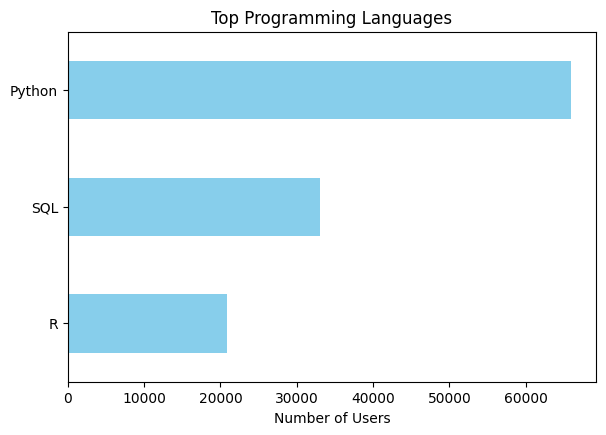

In [24]:
# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Programming Languages
plt.subplot(2, 2, 1)
pd.Series(language_usage).sort_values().plot(kind='barh', color='skyblue')
plt.title('Top Programming Languages')
plt.xlabel('Number of Users')

Text(0, 0.5, '')

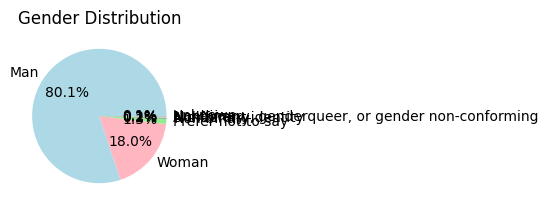

In [30]:
# Plot 2: Gender Distribution
plt.subplot(2, 2, 2)
gender_counts = df['Q2_What is your gender? - Selected Choice'].value_counts()
gender_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightpink', 'lightgreen', 'gray'])
plt.title('Gender Distribution')
plt.ylabel('')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Student'),
  Text(1, 0, 'Data Scientist'),
  Text(2, 0, 'Software Engineer'),
  Text(3, 0, 'Data Analyst'),
  Text(4, 0, 'Other')])

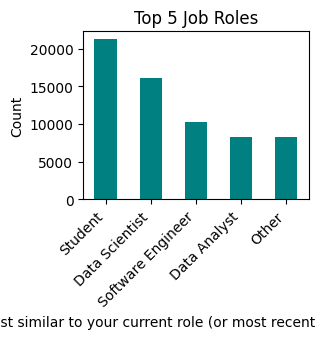

In [31]:
# Plot 3: Top Job Roles
plt.subplot(2, 2, 3)
top_roles = df['Q5_Select the title most similar to your current role (or most recent title if retired): - Selected Choice'].value_counts().head(5)
top_roles.plot(kind='bar', color='teal')
plt.title('Top 5 Job Roles')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

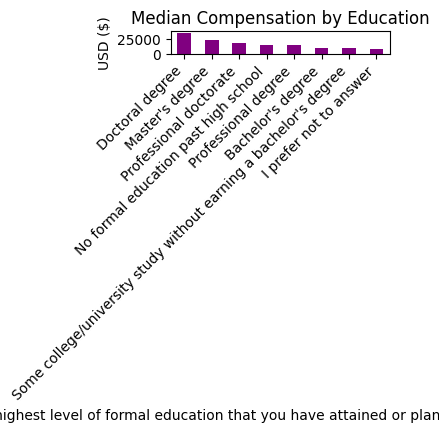

In [32]:
# Plot 4: Compensation by Education
plt.subplot(2, 2, 4)
comp_by_edu = df.groupby('Q4_What is the highest level of formal education that you have attained or plan to attain within the next 2 years?')[comp_col].median().dropna().sort_values(ascending=False)
comp_by_edu.plot(kind='bar', color='purple')
plt.title('Median Compensation by Education')
plt.ylabel('USD ($)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('kaggle_survey_insights.png', dpi=300)
plt.show()

In [33]:
# Step 11: Print Key Insights
print("\n=== Key Insights ===")
print(f"1. Python dominates with {language_usage['Python']} users vs SQL ({language_usage['SQL']}) and R ({language_usage['R']})")
print(f"2. Gender distribution: {gender_counts.get('Man', 0)} men, {gender_counts.get('Woman', 0)} women")
print("3. Top 5 Roles:")
for role, count in top_roles.items():
    print(f"   - {role}: {count} respondents")
print("4. Highest median compensation by education:")
for edu, comp in comp_by_edu.items():
    print(f"   - {edu}: ${comp:,.0f}")


=== Key Insights ===
1. Python dominates with 65941 users vs SQL (33089) and R (20883)
2. Gender distribution: 81586 men, 18328 women
3. Top 5 Roles:
   - Student: 21237 respondents
   - Data Scientist: 16167 respondents
   - Software Engineer: 10252 respondents
   - Data Analyst: 8267 respondents
   - Other: 8223 respondents
4. Highest median compensation by education:
   - Doctoral degree: $35,000
   - Master's degree: $22,500
   - Professional doctorate: $17,500
   - No formal education past high school: $15,010
   - Professional degree: $15,010
   - Bachelor's degree: $10,005
   - Some college/university study without earning a bachelor's degree: $10,005
   - I prefer not to answer: $7,500


In [34]:
# Save cleaned data
df.to_csv('cleaned_kaggle_survey.csv', index=False)

## **Top 5 Insights Dashboard Code**

In [35]:
# Create dashboard figure
plt.figure(figsize=(18, 15))
plt.suptitle('Kaggle Survey 2021: Top 5 Insights', fontsize=22, fontweight='bold')

Text(0.5, 0.98, 'Kaggle Survey 2021: Top 5 Insights')

<Figure size 1800x1500 with 0 Axes>

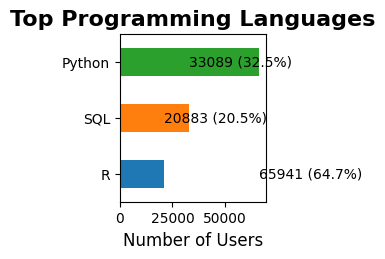

In [37]:
#Insight 1: Programming Languages
plt.subplot(2, 3, 1)
pd.Series(language_usage).sort_values().plot(kind='barh', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Top Programming Languages', fontsize=16, fontweight='bold')
plt.xlabel('Number of Users', fontsize=12)
for i, v in enumerate(language_usage.values()):
    plt.text(v + 10, i, f'{v} ({v/len(df)*100:.1f}%)', va='center')


Text(0, 0.5, '')

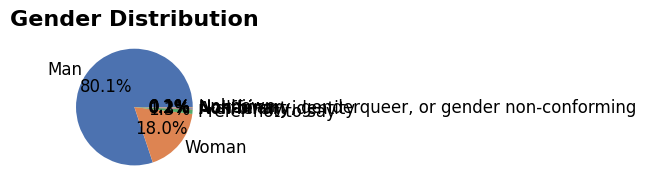

In [41]:
# Right before gender distribution plot:
gender_dist = df['Q2_What is your gender? - Selected Choice'].value_counts()

# Then your existing plot code:
plt.subplot(2, 3, 2)
# Insight 2: Gender Distribution
plt.subplot(2, 3, 2)
gender_dist.plot(kind='pie', autopct='%1.1f%%', 
                 colors=['#4c72b0', '#dd8452', '#55a868', '#c44e52'],
                 textprops={'fontsize': 12})
plt.title('Gender Distribution', fontsize=16, fontweight='bold')
plt.ylabel('')

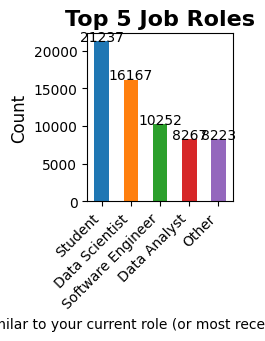

In [42]:
# Insight 3: Top Job Roles
plt.subplot(2, 3, 3)
top_roles.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Top 5 Job Roles', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
for i, v in enumerate(top_roles):
    plt.text(i, v + 5, str(v), ha='center')

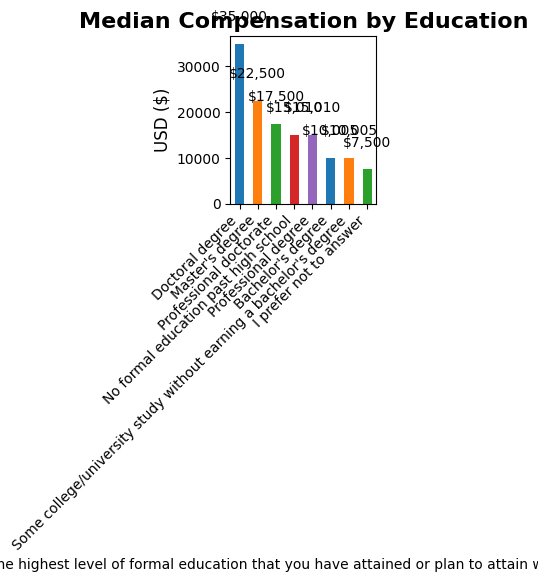

In [43]:
# Insight 4: Compensation by Education
plt.subplot(2, 3, 4)
comp_by_edu.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Median Compensation by Education', fontsize=16, fontweight='bold')
plt.ylabel('USD ($)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
for i, v in enumerate(comp_by_edu):
    plt.text(i, v + 5000, f'${v:,.0f}', ha='center')

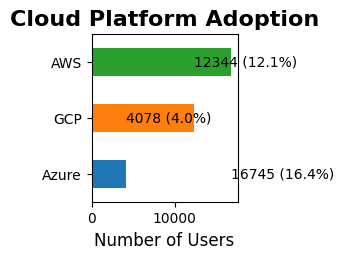

In [47]:
# Insight 5: Cloud Platform Usage
# Dynamically find cloud platform columns
cloud_cols = {}
platforms = {
    'AWS': ['Amazon Web Services', 'AWS'],
    'Azure': ['Microsoft Azure', 'Azure'],
    'GCP': ['Google Cloud Platform', 'GCP']
}

for platform, keywords in platforms.items():
    for col in df.columns:
        if any(keyword in col for keyword in keywords):
            cloud_cols[platform] = col
            break

# Calculate cloud usage
cloud_usage = {}
for platform, col in cloud_cols.items():
    if col in df.columns:
        # Convert to binary indicator
        df[col] = np.where(df[col].astype(str).str.contains(platform[:3], na=False), 1, 0)
        cloud_usage[platform] = df[col].sum()

# Plot if we found columns
if cloud_usage:
    plt.subplot(2, 3, 5)
    pd.Series(cloud_usage).sort_values().plot(kind='barh', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title('Cloud Platform Adoption', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Users', fontsize=12)
    for i, v in enumerate(cloud_usage.values()):
        plt.text(v + 10, i, f'{v} ({v/len(df)*100:.1f}%)', va='center')
else:
    plt.subplot(2, 3, 5)
    plt.text(0.5, 0.5, 'Cloud Platform Data\nNot Available', 
             ha='center', va='center', fontsize=14)
    plt.title('Cloud Platform Adoption', fontsize=16, fontweight='bold')
    plt.axis('off')

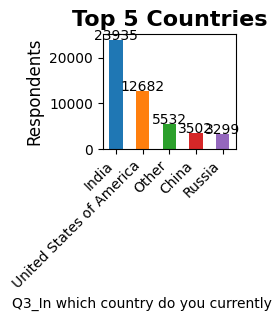

In [51]:
# Insight 6: Country Distribution (Top 5)
plt.subplot(2, 3, 6)
top_countries = df['Q3_In which country do you currently reside?'].value_counts().head(5)
top_countries.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Top 5 Countries', fontsize=16, fontweight='bold')
plt.ylabel('Respondents', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
for i, v in enumerate(top_countries):
    plt.text(i, v + 5, str(v), ha='center')
# Final formatting
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make space for suptitle
plt.savefig('kaggle_survey_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()